# Задание на регрессию. Немного о переобучении и недобучении. Кроссвалидация. Подбор параметров. 

# Полезные ссылки
* [Переобучение и недобучение](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9F%D0%B5%D1%80%D0%B5%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5)
* [Регуляризация](https://neerc.ifmo.ru/wiki/index.php?title=%D0%A0%D0%B5%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F)
* [Линейные модели в sklearn - там же есть Лассо и Ридж регрессия](https://scikit-learn.ru/1-1-linear-models/#ridge-regression-and-classification)
* [Выбор и оценка модели](https://scikit-learn.ru/category/model-selection/)
* [Также про регуляризацию, переобучение и недообучение](https://habr.com/ru/companies/ods/articles/323890/)
* [LASSO и Ridge Регрессия. Что же значит та картинка](https://habr.com/ru/articles/679232/)
* [Кроссвалидация](https://academy.yandex.ru/handbook/ml/article/kross-validaciya)
* [Подбор гиперпараметров](https://academy.yandex.ru/handbook/ml/article/podbor-giperparametrov)
* [Статья Себастьяна Рашка](https://arxiv.org/pdf/1811.12808.pdf)
* [Глава 5. Оценка и улучшение качества модели_стр. 268-295](https://disk.yandex.ru/i/XBzXk58TEP349g)

# Переобучение и недобучение

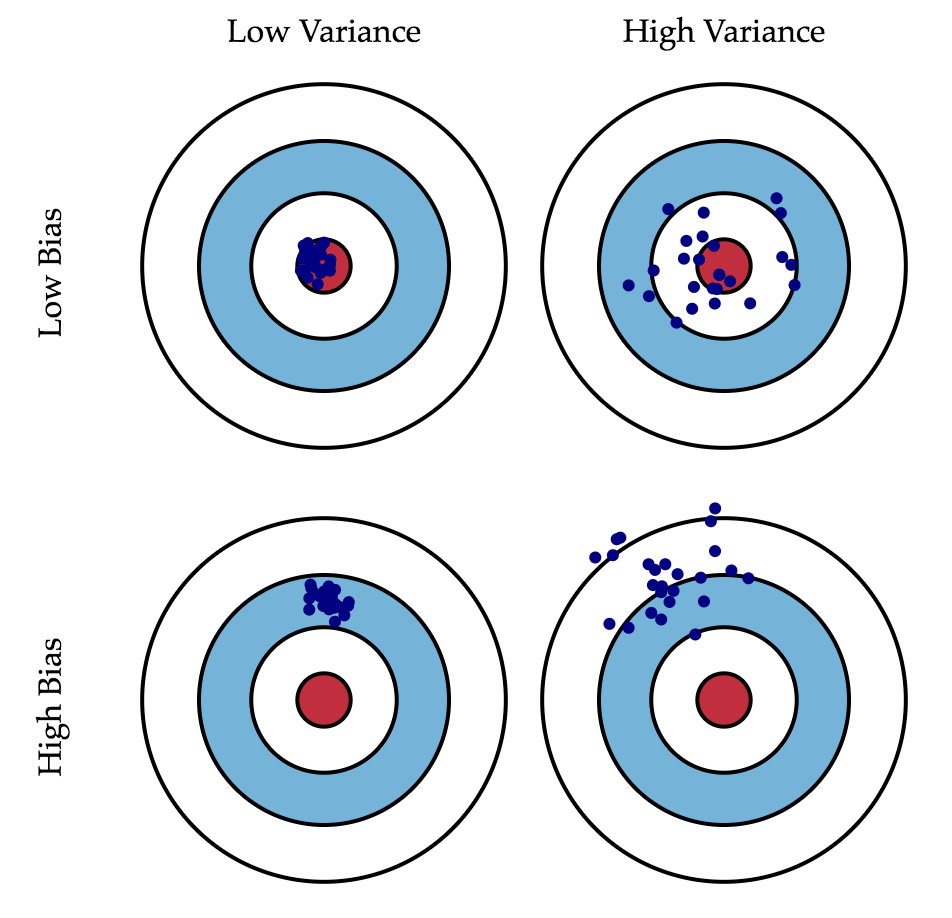

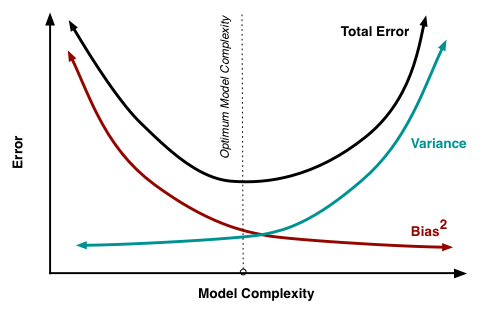

# Кроссвалидация
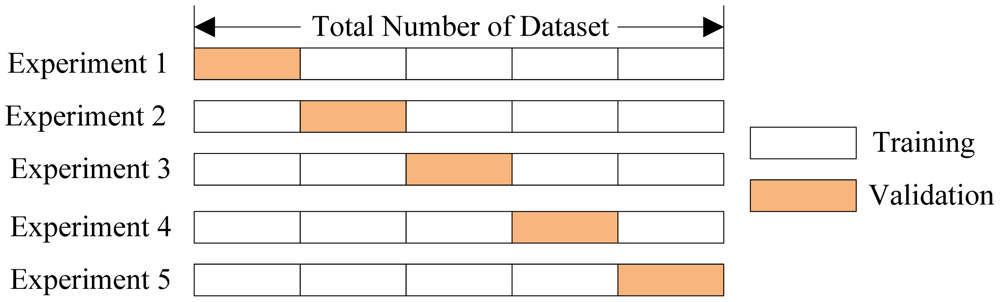

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet, ElasticNetCV # Линейна регрессия, Ридж и Лассо
from sklearn.linear_model import LassoCV, RidgeCV, MultiTaskLassoCV # Ridge и Lasso Регрессия
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import make_scorer, r2_score

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

import gc

sns.set()
%matplotlib inline

import sys
# np.set_printoptions(suppress=True)
# np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)

DISPLAY_MAX_ROWS = 20 #20
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)
pd.set_option('display.max_column',None) 
plt.style.use('seaborn-whitegrid')


# plt.rcParams["figure.figsize"] = (20, 15)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("data.csv")

In [6]:
df

,KS4_GPA5_Qtg.PV,KS4_GPA5_TC_T1.PV,KS4_GPA5_Nst.PV,KS4_GPA5_Nvd.PV,KS4_GPA5_Nnd.PV,KS4_GPA5_T4.PV,KS4_GPA5_Pk.PV
0,50.074285,50.656771,500.475537,1207.542773,912.161426,119.562970,51.248955
1,50.074926,50.656771,500.379883,1209.190723,914.203027,119.683643,51.255357
2,50.074836,50.666920,499.359570,1210.159082,914.924512,119.665576,51.263570
3,50.074957,50.666920,500.535840,1210.641602,915.881055,119.674750,51.267725
4,50.075145,50.666920,500.198145,1211.398438,916.435645,119.692188,51.264826
...,...,...,...,...,...,...,...
29707,50.070496,52.706500,459.827393,1238.176660,914.571973,128.579962,51.102349
29708,50.070217,52.716716,459.400806,1237.532422,913.476074,128.521655,51.102543
29709,50.070292,52.696284,459.942578,1237.783984,913.913086,128.503632,51.102639
29710,50.070389,52.675853,460.185791,1237.441895,913.895508,128.481744,51.103799


In [45]:
inputs = ['KS4_GPA5_Qtg.PV', 'KS4_GPA5_TC_T1.PV', 'KS4_GPA5_Nst.PV'] # предикторы
outputs = ['KS4_GPA5_Nvd.PV', 'KS4_GPA5_Nnd.PV', 'KS4_GPA5_T4.PV', 'KS4_GPA5_Pk.PV'] # отклики, целевые признаки

# Задача - построить предсказательую модель outputs по inputs
### Результатом решения задачи является код эксперимента в Jupyter Notebook, содержащий качественное обоснование выбора той или иной архитектуры (метода). В качестве base line рекомендуется выбрать модель линейной регрессии. 

# ДЗ: 
1. Сделать разведочный анализ данных, найти пропуски и выбросы. Примеры есть в ноутбуке EDA_AUTO из 4 задания.
2. Заполнить пропуски. Заполнить медианой или обучить линейную регрессию и заполнить ею пропуски. Если заполните линейной регрессией пропуски, то с помощью таблицы корреляций найдите второй признак, который имеет сильную взаимосвязь с первым признаком. Создаете отдельный датафрейм из этих признаков, исключаете пропуски (не удаляете), обучаете линейну регрессию. Затем прогнозируете на исключенных данных с пропусками и заполняете эти пропуски предсказанным значением.
3. Обучить множественную линейную регрессию. Она будет являться base line, т.е. базовая модель. С ней вы будете сравнивать другие модели.
4. Используя кроссвалидацию, подбор гиперпараметров обучить модели Lasso regression, Ridge Regression, ElasticNet (модель где Ridge + Lasso вместе используется), DecisionTreeRegressor, SVR, RandomForestRegressor

5. `alphas=[0.0001, 0.001,0.01, 0.1, 1, 10]` - для MultiTaskLassoCV, RidgeCV, и для ElasticNetCV.

`'l1_ratio':[0.01, 0.1, 0.5, 1, 5, 10, 15, 20]` - для ElasticNetCV

6. **для SVR и RandomForest:**
```python
param_grid = [{'regressor':[SVR()], 'preprocessing':[StandardScaler(), None],
              'regressor__gamma':[0.001, 0.01, 0.1, 1, 10, 100],
               'regressor__C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'regressor': [DecisionTreeRegressor()],
               'preprocessing': [None], 
               'regressor__max_features': [1, 2, 3]},
              {'regressor': [RandomForestRegressor(n_estimators=100)],
               'preprocessing': [None], 
               'regressor__max_features': [1, 2, 3]}]
```

7. **Если SVR обучается, то используем только этот набор параметров:**
```python
param_grid={
    'estimator__gamma': [0.001, 0.01],
    'estimator__C': [0.001, 0.01],
}
```